In [14]:
import pandas as pd

vcb = pd.read_csv("./Data/vcb_2010-2024.csv")
vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('Date', inplace=True)
vcb

/tmp/ipykernel_23308/2547231115.py:4: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,13842,14519,13842,14519,2032674
2010-01-05,15020,15167,14519,14667,3175256
2010-01-06,14166,14667,14136,14136,1629290
2010-01-07,14136,14166,13842,13842,704530
2010-01-08,14019,14078,13812,13842,1193887
...,...,...,...,...,...
2024-05-27,90400,90600,89700,90200,1258620
2024-05-28,89800,90700,89800,90700,1814349
2024-05-29,90800,91000,89800,89800,1186438


## BiLSTM

/tmp/ipykernel_23308/884245980.py:11: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)
/home/tuyen/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


             Open   High    Low  Close   Volume
Date                                           
2010-01-04  13842  14519  13842  14519  2032674
2010-01-05  15020  15167  14519  14667  3175256
2010-01-06  14166  14667  14136  14136  1629290
2010-01-07  14136  14166  13842  13842   704530
2010-01-08  14019  14078  13812  13842  1193887
2776/2776 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - loss: 0.0013
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


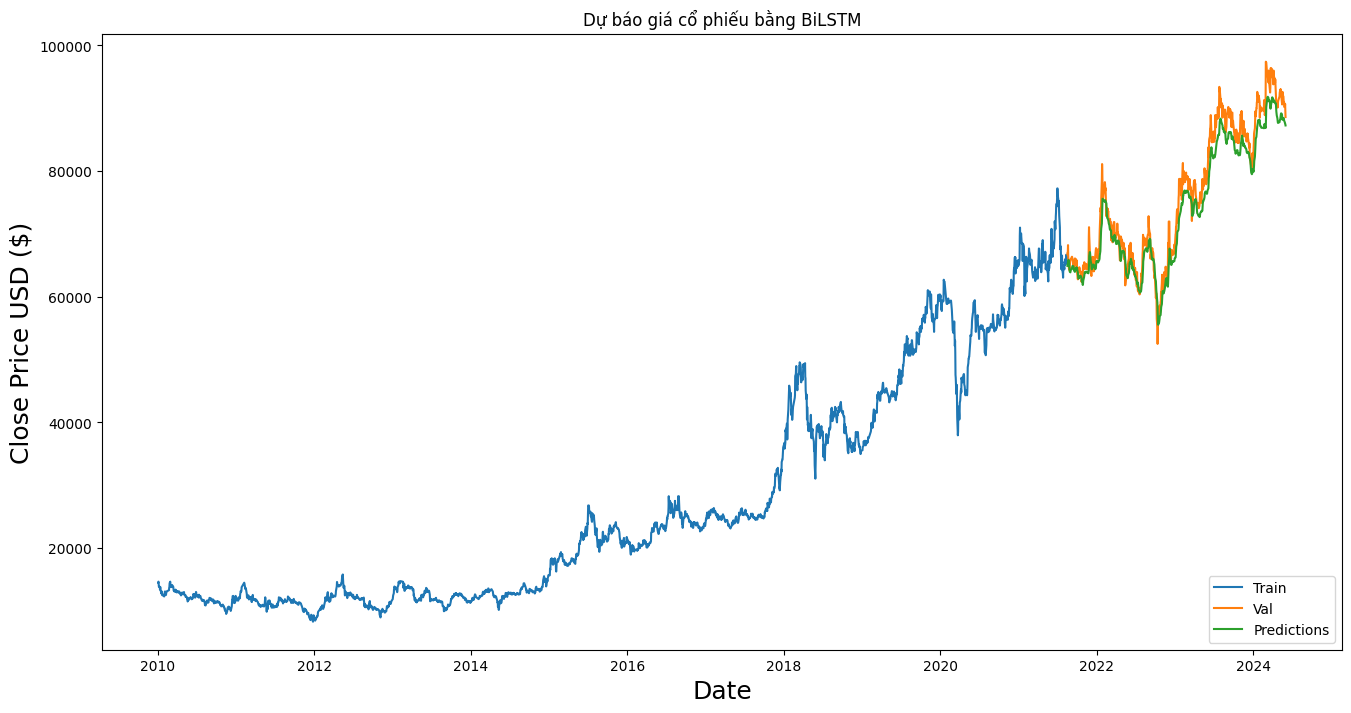

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

# Đọc dữ liệu
vcb = pd.read_csv("./Data/vcb_2010-2024.csv")
vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('Date', inplace=True)

# Đảm bảo rằng dữ liệu được hiển thị
print(vcb.head())

# Chọn cột Close cho dự báo
close_prices = vcb['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

# Chuẩn bị dữ liệu cho mô hình BiLSTM
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 120  # Số lượng bước thời gian
X, y = create_dataset(scaled_close, look_back)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Reshape dữ liệu thành dạng [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# Xây dựng mô hình BiLSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, 1)))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

# Biên dịch và huấn luyện mô hình
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, batch_size=1, epochs=1)

# Dự báo trên tập kiểm tra
predictions = model.predict(test_X)
predictions = scaler.inverse_transform(predictions)

# Cắt bớt `valid` hoặc `predictions` để khớp chiều dài
valid = vcb[train_size + look_back:].copy()
valid = valid.iloc[:len(predictions)]

# Thêm cột dự báo vào DataFrame `valid`
valid['Predictions'] = predictions

# Vẽ biểu đồ kết quả
plt.figure(figsize=(16, 8))
plt.title('Dự báo giá cổ phiếu bằng BiLSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(vcb.index[:train_size + look_back], vcb['Close'][:train_size + look_back], label='Train')
plt.plot(valid.index, valid['Close'], label='Val')
plt.plot(valid.index, valid['Predictions'], label='Predictions')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


## Mo hinh khac

/tmp/ipykernel_23308/1450156473.py:9: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)


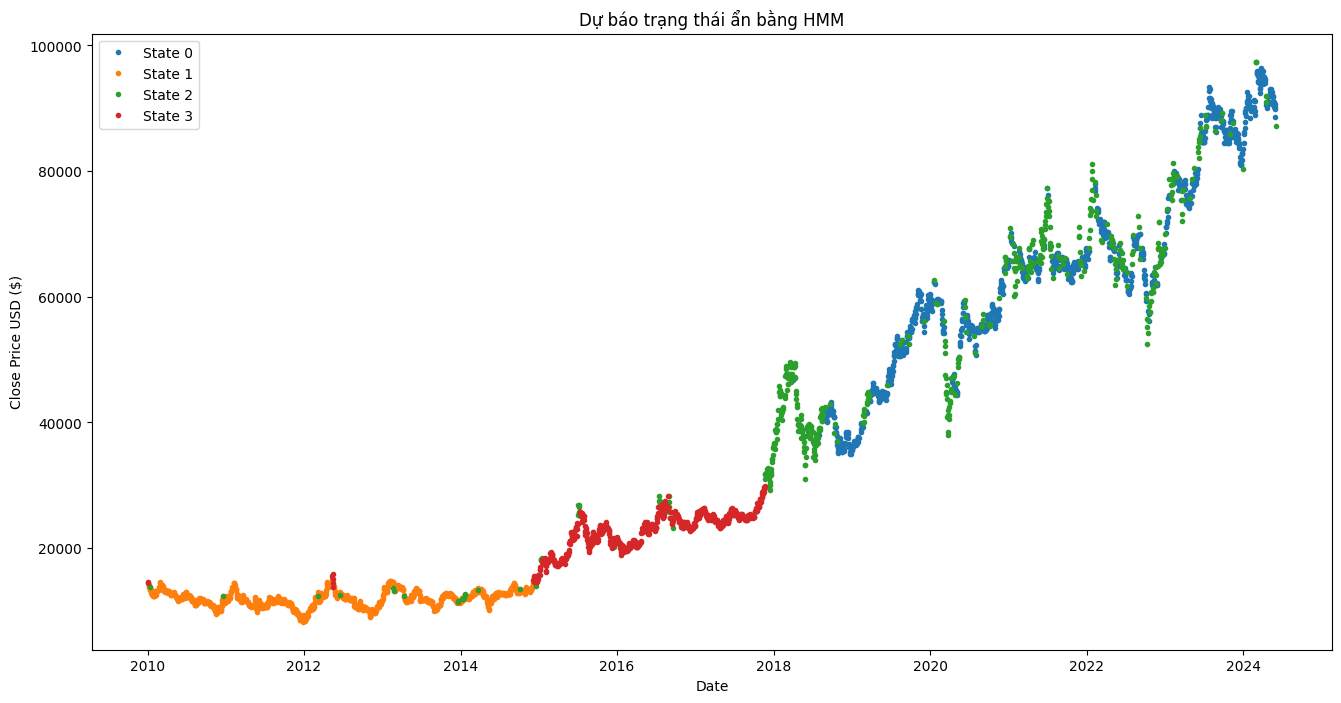

TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'

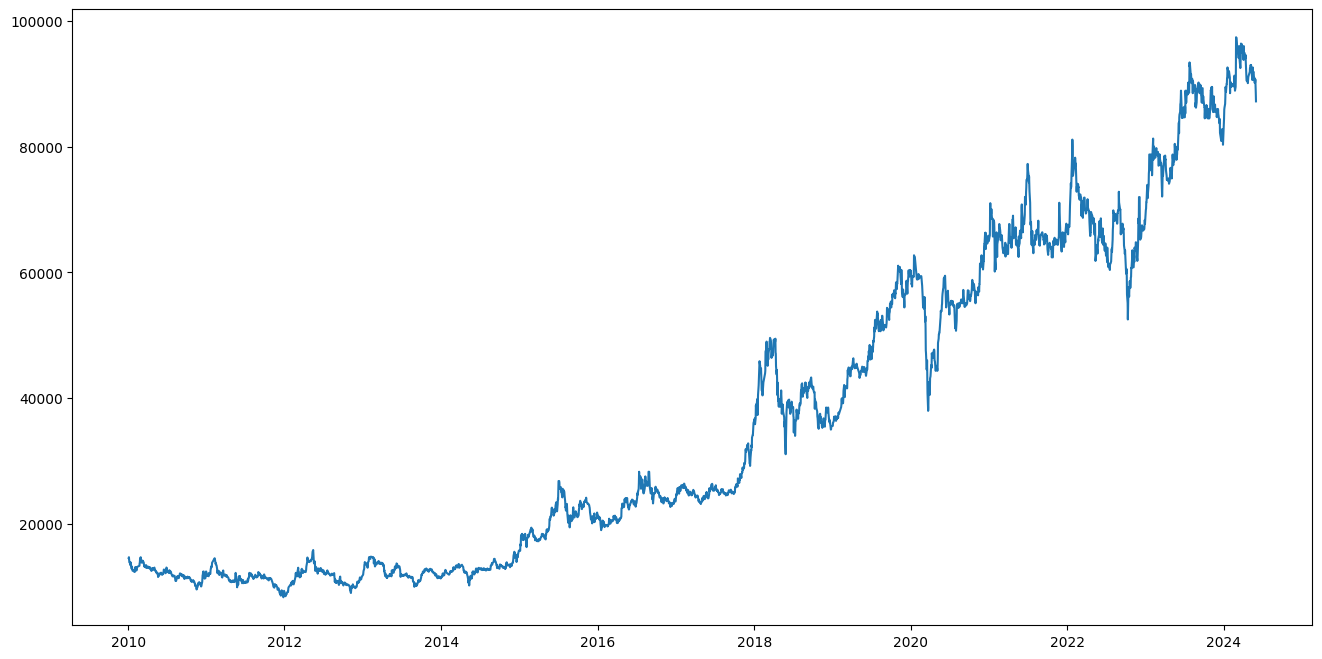

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu
vcb = pd.read_csv("./Data/vcb_2010-2024.csv")
vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('Date', inplace=True)

# Lấy cột Close cho dự báo
close_prices = vcb['Close'].values

# Tạo các đặc trưng (features) từ dữ liệu
data = vcb[['Close', 'High', 'Low', 'Volume']].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Định nghĩa và huấn luyện mô hình HMM
n_components = 4  # Số trạng thái ẩn
model = GaussianHMM(n_components=n_components, covariance_type='full', n_iter=1000)
model.fit(scaled_data)

# Dự báo trạng thái ẩn cho dữ liệu
hidden_states = model.predict(scaled_data)

# Thêm cột trạng thái ẩn vào DataFrame
vcb['Hidden State'] = hidden_states

# Vẽ biểu đồ kết quả
plt.figure(figsize=(16, 8))

# Vẽ giá Close và trạng thái ẩn
for i in range(n_components):
    state = (hidden_states == i)
    plt.plot(vcb.index[state], vcb['Close'][state], '.', label=f'State {i}')

plt.title('Dự báo trạng thái ẩn bằng HMM')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

# Dự báo giá trị tương lai dựa trên trạng thái ẩn hiện tại
last_hidden_state = hidden_states[-1]
future_steps = 30  # Số bước dự báo trong tương lai

future_prices = []
current_data = scaled_data[-1].reshape(1, -1)

for _ in range(future_steps):
    future_hidden_state = model.predict(current_data)[0]
    mean = model.means_[future_hidden_state]
    cov = model.covars_[future_hidden_state]
    
    # Đảm bảo ma trận hiệp phương sai là vuông và hai chiều
    if cov.ndim == 1:
        cov = np.diag(cov)
    
    future_price = np.random.multivariate_normal(mean, cov)
    future_prices.append(scaler.inverse_transform(future_price.reshape(1, -1))[0][0])
    current_data = future_price.reshape(1, -1)

# Vẽ biểu đồ dự báo giá trị tương lai
plt.figure(figsize=(16, 8))
plt.plot(vcb.index, vcb['Close'], label='Historical Close Prices')
plt.plot(pd.date_range(start=vcb.index[-1], periods=future_steps+1, closed='right'), future_prices, label='Predicted Future Prices')
plt.title('Dự báo giá cổ phiếu bằng HMM')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()
